# Music Recommender System

In [1]:
%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation
from scipy.sparse import csr_matrix

# Load music dataset

In [2]:
# define the two files, I was working with
    #the triple file contains (user_id, song_id and listen time in text format)
    #songs metadata file contains song_id, song title, release_by and artist_name
triplets_file = 'E:/AAU IS 2019/Sem-2/Data Analytics and Visualization/1-Music recomender/triplet_file.txt'
songs_metadata_file = 'E:/AAU IS 2019/Sem-2/Data Analytics and Visualization/1-Music recomender/song_data.csv'

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 

# Explore the data

Music data shows how many times a user listened to a song, as well as the details of the song.

In [3]:
song_df.head(10)

,user_id,song_id,listen_count,song,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1.0,The Cove,Thicker Than Water,Jack Johnson,0.0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2.0,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976.0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1.0,Stronger,Graduation,Kanye West,2007.0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1.0,Constellations,In Between Dreams,Jack Johnson,2005.0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1.0,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999.0
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5.0,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007.0
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1.0,Paper Gangsta,The Fame Monster,Lady GaGa,2008.0
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1.0,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,1999.0
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1.0,Sehr kosmisch,Musik von Harmonia,Harmonia,0.0
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1.0,Heaven's gonna burn your eyes,Hôtel Costes 7 by Stéphane Pompougnac,Thievery Corporation feat. Emiliana Torrini,2002.0


## Length of the dataset

In [4]:
len(song_df)

28981

## Create a subset of the dataset

In [5]:
song_df = song_df.head(12000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['song'].map(str) + " - " + song_df['artist_name']

## Showing the most popular songs in the dataset

In [6]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1]).head(10)

,song,listen_count,percentage
4107,Sehr kosmisch - Harmonia,51,0.425000
1191,Dog Days Are Over (Radio Edit) - Florence + Th...,38,0.316667
5253,Undo - Björk,38,0.316667
3896,Revelry - Kings Of Leon,35,0.291667
4101,Secrets - OneRepublic,34,0.283333
5733,You're The One - Dwight Yoakam,34,0.283333
4920,The Scientist - Coldplay,30,0.250000
5291,Use Somebody - Kings Of Leon,29,0.241667
1552,Fireflies - Charttraxx Karaoke,28,0.233333
2076,Horn Concerto No. 4 in E flat K495: II. Romanc...,27,0.225000


## Count number of unique users in the dataset

In [7]:
users = song_df['user_id'].unique()
len(users)

442

## Count the number of unique songs in the dataset

In [8]:
###Fill in the code here
songs = song_df['song'].unique()
len(songs)

5780

# Create a Music recommender

In [9]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(3))

                                       user_id             song_id  \
843   baf47ed8da24d607e50d8684cde78b923538640f  SORWPCP12A8C13B9D8   
9450  97e48f0f188e04dcdb0f8e20a29dacb881d80c9e  SOYJETS12A8C13ECC7   
7766  390c2e81bc9cf885608a0891c0a7eb13f1fd3336  SOUVTSM12AC468F6A7   

      listen_count                                      song         release  \
843            2.0                     Tape Song - The Kills   Midnight Boom   
9450           1.0  The Body Says No - The New Pornographers   Mass Romantic   
7766           1.0       Drop The World - Lil Wayne / Eminem  Drop The World   

                artist_name    year  
843               The Kills  2008.0  
9450  The New Pornographers  2000.0  
7766     Lil Wayne / Eminem     0.0  


### Create an instance of popularity based recommender class

In [11]:
#Recommenders.popularity_recommender_py
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### Use the popularity model to make some predictions
In this case the sample predicted music for user 5 are as follow

In [12]:
user_id = users[3]
pm.recommend(user_id)

,user_id,song,score,Rank
3628,8937134734f869debcab8f23d77465b4caaa85df,Sehr kosmisch - Harmonia,45,1.0
1040,8937134734f869debcab8f23d77465b4caaa85df,Dog Days Are Over (Radio Edit) - Florence + Th...,31,2.0
3448,8937134734f869debcab8f23d77465b4caaa85df,Revelry - Kings Of Leon,29,3.0
4634,8937134734f869debcab8f23d77465b4caaa85df,Undo - Björk,29,4.0
5045,8937134734f869debcab8f23d77465b4caaa85df,You're The One - Dwight Yoakam,28,5.0
3622,8937134734f869debcab8f23d77465b4caaa85df,Secrets - OneRepublic,27,6.0
1364,8937134734f869debcab8f23d77465b4caaa85df,Fireflies - Charttraxx Karaoke,23,7.0
4669,8937134734f869debcab8f23d77465b4caaa85df,Use Somebody - Kings Of Leon,23,8.0
774,8937134734f869debcab8f23d77465b4caaa85df,Clocks - Coldplay,22,9.0
1778,8937134734f869debcab8f23d77465b4caaa85df,Hey_ Soul Sister - Train,22,10.0


### Quiz 2: Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [41]:
###Fill in the code here, but the results is steel the same, why??
user_id = users[6]
pm.recommend(user_id)

,user_id,song,score,Rank
3628,e006b1a48f466bf59feefed32bec6494495a4436,Sehr kosmisch - Harmonia,45,1.0
1040,e006b1a48f466bf59feefed32bec6494495a4436,Dog Days Are Over (Radio Edit) - Florence + Th...,31,2.0
3448,e006b1a48f466bf59feefed32bec6494495a4436,Revelry - Kings Of Leon,29,3.0
4634,e006b1a48f466bf59feefed32bec6494495a4436,Undo - Björk,29,4.0
5045,e006b1a48f466bf59feefed32bec6494495a4436,You're The One - Dwight Yoakam,28,5.0
3622,e006b1a48f466bf59feefed32bec6494495a4436,Secrets - OneRepublic,27,6.0
1364,e006b1a48f466bf59feefed32bec6494495a4436,Fireflies - Charttraxx Karaoke,23,7.0
4669,e006b1a48f466bf59feefed32bec6494495a4436,Use Somebody - Kings Of Leon,23,8.0
774,e006b1a48f466bf59feefed32bec6494495a4436,Clocks - Coldplay,22,9.0
1778,e006b1a48f466bf59feefed32bec6494495a4436,Hey_ Soul Sister - Train,22,10.0


## Build a song recommender with personalization

We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user. 

In [ ]:
#Recommenders.item_similarity_recommender_py

### Create an instance of item similarity based recommender class

In [14]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### Use the personalized model to make some song recommendations

In [22]:
#Print the songs for the user in training data
user_id = users[7]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 7
no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :3049


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.266667,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.266667,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Voyager - Daft Punk,0.266667,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.266667,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Out At The Pictures - Hot Chip,0.266667,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.266667,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.266667,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Adjustor - Octopus Project,0.266667,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.266667,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.266667,10


### Quiz 3. Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [40]:
#Fill in the code here
user_id = users[5]
is_model.recommend(user_id)

No. of unique songs for the user: 13
no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :2313


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.080963,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.075293,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.053859,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Favorite Girl - Justin Bieber,0.048596,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.047798,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm On A Boat - The Lonely Island / T-Pain,0.047192,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.046497,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Overboard - Justin Bieber / Jessica Jarrell,0.046154,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Teach Me How To Dougie - California Swag District,0.044448,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Killing In The Name - Rage Against The Machine,0.044379,10


### We can also apply the model to find similar songs to any song in the dataset

In [25]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :197


,user_id,song,score,rank
0,,Hace Tiempo - Fonseca,0.400000,1
1,,Down To Earth - Justin Bieber,0.400000,2
2,,What You Know - Two Door Cinema Club,0.333333,3
3,,Monster - Lady GaGa,0.300000,4
4,,Paper Planes - M.I.A.,0.300000,5
5,,Killing In The Name - Rage Against The Machine,0.285714,6
6,,Stuck In The Moment - Justin Bieber,0.285714,7
7,,Favorite Girl - Justin Bieber,0.285714,8
8,,Somebody To Love - Justin Bieber,0.277778,9
9,,One - Metallica,0.250000,10


### Quiz 4. Use the personalized recommender model to get similar songs for the following song.

In [42]:

###Fill in the code here
is_model.get_similar_items(['Favorite Girl - Justin Bieber'])

no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :202


,user_id,song,score,rank
0,,Stuck In The Moment - Justin Bieber,0.600000,1
1,,Down To Earth - Justin Bieber,0.500000,2
2,,One Time - Justin Bieber,0.400000,3
3,,That Should Be Me - Justin Bieber,0.285714,4
4,,U Smile - Justin Bieber,0.285714,5
5,,Eenie Meenie - Sean Kingston and Justin Bieber,0.285714,6
6,,Common Denominator - Justin Bieber,0.250000,7
7,,Docking Bay 94 - The Alter Boys,0.250000,8
8,,Bottom of a Bottle (Explicit Album Version) - ...,0.250000,9
9,,Wait & See (Gucci Soundsystem Remix) - Tiefsch...,0.250000,10


# Quantitative comparison between the models

We now formally compare the popularity and the personalized models using precision-recall curves. 

In [20]:
#Evaluation.precision_recall_calculator

## Use the above precision recall calculator class to calculate the evaluation measures

In [27]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:386
Length of user sample:19
Getting recommendations for user:c2cffe9ccaa09a327e8134e9a1f24901801fb2f8
No. of unique songs for the user: 5
no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :514
Getting recommendations for user:12a4a991c8b53cd6906995caed8b1f2bd3b6436a
No. of unique songs for the user: 94
no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :15063
Getting recommendations for user:610eaa449a4793ea791ff12252845f6002794c2a
No. of unique songs for the user: 24
no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :1059
Getting recommendations for user:4600442e761b6f636a08134b10b9b6c38cef6ba4
No. of unique songs for the user: 13
no. of unique songs in the training set: 5089
Non zero values in cooccurence_matrix :1374
Getting recommendations for user:9c2032efba612bccec98435a3928b67d69350bed
No. of unique songs for the user: 7
no. of unique songs in th

## Code to plot precision recall curve

In [43]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


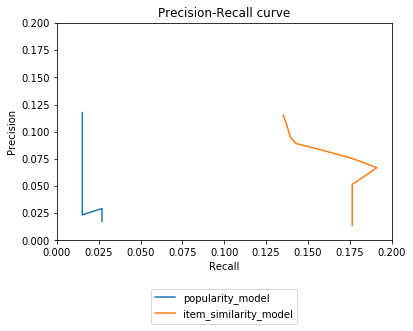

In [44]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model", 
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


### Generate Precision Recall curve using pickled results on a larger data subset(Python 3)

Plotting precision recall curves for a larger subset of data (12,000 rows) (user sample = 0.05).
Plotting precision recall curves.


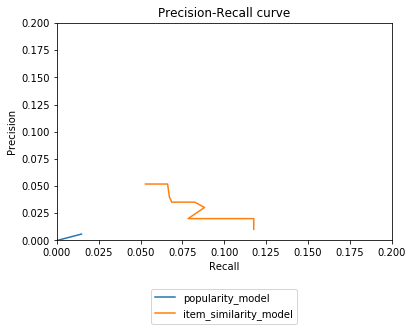

In [45]:
print("Plotting precision recall curves for a larger subset of data (12,000 rows) (user sample = 0.05).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

### Generate Precision Recall curve using pickled results on a larger data subset
You can read any “pickled” object stored in a file by using the built-in pickle directly,or even more conveniently using pandas.read_pickle:

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


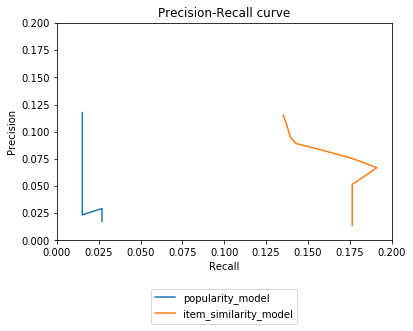

In [37]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

pm_avg_precision_list = joblib.load('pm_avg_precision_list_2.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_2.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_2.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_2.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

   ### So, the curve shows that the personalized model provides much better performance over the popularity model. 

# Thank You!!